In [1]:
# Adrian Marinovich
# Springboard - Data Science Career Track
# Inferential Statistics Exercise 3
# October 10, 2018

# Hospital Readmissions Data Analysis and Recommendations for Reduction

### Background
In October 2012, the US government's Center for Medicare and Medicaid Services (CMS) began reducing Medicare payments for Inpatient Prospective Payment System hospitals with excess readmissions. Excess readmissions are measured by a ratio, by dividing a hospital’s number of “predicted” 30-day readmissions for heart attack, heart failure, and pneumonia by the number that would be “expected,” based on an average hospital with similar patients. A ratio greater than 1 indicates excess readmissions.

### Exercise Directions

In this exercise, you will:
+ critique a preliminary analysis of readmissions data and recommendations (provided below) for reducing the readmissions rate
+ construct a statistically sound analysis and make recommendations of your own 

More instructions provided below. Include your work **in this notebook and submit to your Github account**. 

### Resources
+ Data source: https://data.medicare.gov/Hospital-Compare/Hospital-Readmission-Reduction/9n3s-kdb3
+ More information: http://www.cms.gov/Medicare/medicare-fee-for-service-payment/acuteinpatientPPS/readmissions-reduction-program.html
+ Markdown syntax: http://nestacms.com/docs/creating-content/markdown-cheat-sheet
****

In [81]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import bokeh.plotting as bkp
from mpl_toolkits.axes_grid1 import make_axes_locatable

import os
import string

import scipy

from sklearn.svm import LinearSVC 
from sklearn.svm import SVC 

from sklearn.datasets import fetch_mldata
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.utils import resample

from scipy.stats import reciprocal, uniform
from scipy.stats import pearsonr

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz

import warnings
warnings.filterwarnings('ignore')

In [9]:
# read in readmissions data provided
hospital_read_df = pd.read_csv('data/cms_hospital_readmissions.csv')

****
## Preliminary Analysis

In [10]:
# deal with missing and inconvenient portions of data 
clean_hospital_read_df = hospital_read_df[hospital_read_df['Number of Discharges'] != 'Not Available']
clean_hospital_read_df.loc[:, 'Number of Discharges'] = clean_hospital_read_df['Number of Discharges'].astype(int)
clean_hospital_read_df = clean_hospital_read_df.sort_values('Number of Discharges')

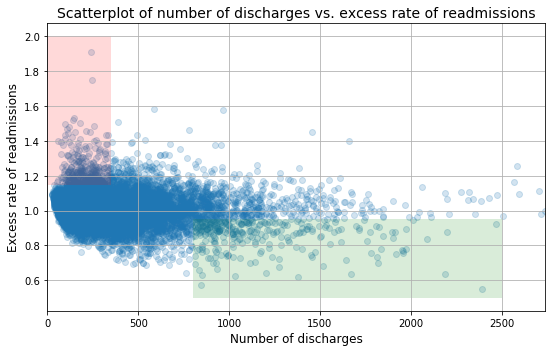

In [4]:
# generate a scatterplot for number of discharges vs. excess rate of readmissions
# lists work better with matplotlib scatterplot function
x = [a for a in clean_hospital_read_df['Number of Discharges'][81:-3]]
y = list(clean_hospital_read_df['Excess Readmission Ratio'][81:-3])

fig, ax = plt.subplots(figsize=(8,5))
ax.scatter(x, y,alpha=0.2)

ax.fill_between([0,350], 1.15, 2, facecolor='red', alpha = .15, interpolate=True)
ax.fill_between([800,2500], .5, .95, facecolor='green', alpha = .15, interpolate=True)

ax.set_xlim([0, max(x)])
ax.set_xlabel('Number of discharges', fontsize=12)
ax.set_ylabel('Excess rate of readmissions', fontsize=12)
ax.set_title('Scatterplot of number of discharges vs. excess rate of readmissions', fontsize=14)

ax.grid(True)
fig.tight_layout()

****

## Preliminary Report

Read the following results/report. While you are reading it, think about if the conclusions are correct, incorrect, misleading or unfounded. Think about what you would change or what additional analyses you would perform.

**A. Initial observations based on the plot above**
+ Overall, rate of readmissions is trending down with increasing number of discharges
+ With lower number of discharges, there is a greater incidence of excess rate of readmissions (area shaded red)
+ With higher number of discharges, there is a greater incidence of lower rates of readmissions (area shaded green) 

**B. Statistics**
+ In hospitals/facilities with number of discharges < 100, mean excess readmission rate is 1.023 and 63% have excess readmission rate greater than 1 
+ In hospitals/facilities with number of discharges > 1000, mean excess readmission rate is 0.978 and 44% have excess readmission rate greater than 1 

**C. Conclusions**
+ There is a significant correlation between hospital capacity (number of discharges) and readmission rates. 
+ Smaller hospitals/facilities may be lacking necessary resources to ensure quality care and prevent complications that lead to readmissions.

**D. Regulatory policy recommendations**
+ Hospitals/facilties with small capacity (< 300) should be required to demonstrate upgraded resource allocation for quality care to continue operation.
+ Directives and incentives should be provided for consolidation of hospitals and facilities to have a smaller number of them with higher capacity and number of discharges.

****
### Exercise

Include your work on the following **in this notebook and submit to your Github account**. 

See below...

A. Do you agree with the above analysis and recommendations? Why or why not?

The above analysis appears to be flawed for two main reasons:
- It relies on a weak correlation that appears driven by a relatively small number of outliers in the pink and green boxes.
- It makes an apples-to-oranges comparison between hospitals, in putting all hospitals together without differentiation, as seen by the single cluster spread out over the above plot.

_An approach to differentiate the hospitals, and in so doing to obtain a metric that correlates more strongly with the excess readmission ratio (ERR), is described in part B below._

The above authors state there is a 'significant correlation between hospital capacity (number of discharges) and readmission rates' without specifying the statistical test used to support this conclusion. As calculated below, while the Pearson correlation coefficient for discharge number on ERR is significant, it shows only a slight negative linear correlation: the coefficient is only -0.093 (-1 would indicate an exact negative linear relationship). 

Another criticism of the above analysis concerns the inconsistent use of thresholds, and their use without supporting statistics. The above statistics section sets <100 and >1000 discharges as thresholds to compare ERR means and ERR>1 proportions between hospitals, without showing statistical significance testing. In their conclusion the above authors set discharges <300 as the threshold for their recommendation, without showing a statistical analysis to support that different threshold, or explaining why that threshold differs from those used in their statistics section.

Finally, on a more detailed note, the above authors refer to the ERR as a 'rate', when it is actually a ratio.

In conclusion, the above analysis appears to be misleading.

B. Provide support for your arguments and your own recommendations with a statistically sound analysis:

_Question 5 is answered first, as its answer lays the groundwork for the answers to Questions 1 through 4._

Q5. Look at the scatterplot above.
- What are the advantages and disadvantages of using this plot to convey information?

As noted in the answer to part A above, the above scatterplot groups the hospitals together into a single main cluster. Grouping all hospitals together may have the advantage of leading to more broadly or easily generalizable conclusions. In this case, however, the grouping leads the authors to find a weak correlation that appears driven primarily by the small number of outliers, so that any advantage conferred by a single cluster does not apply. The approach becomes a disadvantage, since their conclusions would seem to apply mainly to the outliers.

- Construct another plot that conveys the same information in a more direct manner.

Below, to try to differentiate hospitals, the discharge number is normalized by dividing it by the readmission number for each hospital. This ratio might serve as a 'patient mix' metric whereby a higher ratio indicating less patient returns to the hospital per discharge implies an overall less complex patient mix for that hospital. This ratio (D/R) is then plotted against the excess readmission ratio (ERR) to reveal two distinct groups (or clusters) of hospitals (see Figure 1, below). 

Perhaps the differentiation seen in Figure 1 is the result of hospitals with high D/R (right cluster, called 'Cluster 1') seeing low-comorbidity patients, possibly including those with many patients using short-stay surgical and/or maternity centers within the hospital, splitting off into a separate group from those hospitals with low D/R (left cluster, called 'Cluster 0') handling more complex high-comorbidity patients. 

Whatever the underlying explanation, Figure 1 appears to convey more useful information than the plot in the above analysis. Aside from splitting the hospitals into two groups, the groups show interesting features not previously appreciable in the above plot. First, both groups show unmistakable _local_ trends towards lower ERR (better performance) with higher D/R, which stands in contrast to the less obvious ERR trend with discharge number seen above. Furthermore, the right group with _overall_ higher D/R shows the _overall_ greatest spread of ERR, and in fact shows most of the _overall_ worst-performing hospitals. This indicates this particular group may be most worthy of special consideration in efforts to improve performance.


Q1. Setup an appropriate hypothesis test.

There are two hypotheses:
 - Both clusters seen in Figure 1 show a significant correlation between D/R and ERR that is stronger than the  correlation seen for the above analysis.
 - There is a significant difference between the ERR means of the two clusters.

To perform this testing, the clusters are first classified using an unsupervised machine learning approach. Briefly, this approach proceeds in the following steps:

 - A rough cluster classification is performed using DBSCAN, which leaves some data points labelled as noise
 - The two non-noise DBSCAN labels are used to train a support vector machine (SVM) classifier model
 - The SVM model is applied to the full dataset to classify the two clusters without any noise

Next, the Pearson correlation coefficients are calculated separately for the two clusters, and then the ERR means for the two clusters are compared using a t-test. 

Q2. Compute and report the observed significance value (or p-value).
Q3. Report statistical significance for α= .01.

For Cluster 0, the Pearson correlation coefficient for D/R on ERR is: -0.74472. For Cluster 1, the Pearson correlation coefficient for D/R on ERR is: -0.89797. The p-values for both of these correlation coefficients are very close to zero, and therefore much less than 0.01 (_i.e._, they are easily significant at α= .01). Both clusters' correlation coefficients are substantially larger than the correlation coefficient of discharge number on ERR for the above analysis, which was -0.093.

Using the t-test, the p-value for difference between the Cluster 0 and Cluster 1 ERR means is 1.4622092535107237e-18, showing the difference is easily significant at α= .01.

(See calculations below, at end of this notebook.)

Q4. Discuss statistical significance and practical significance. Do they differ here? How does this change your recommendation to the client?

While the linear correlation between discharge number and ERR is significant, it is a weak correlation and therefore may not support clear or broad conclusions or recommendations (_i.e._, it is a correlation with statistical but not much practical significance). The stronger correlation between D/R and ERR described above appear to support a conclusion that D/R ratio can be used as a metric _within each cluster_, and a recommendation that hospitals with a lower D/R metric _within each cluster_ merit increased efforts (such as enhanced discharge planning) to prevent excess readmission. In addition, it is recommended that Cluster 1 hospitals be examined for factors that contribute their high variability in ERR.

In carrying out these recommendations, it would help to have more information on what determines a given hospital's cluster. The search for features classifying hospitals into clusters shown below is preliminary. Further work, likely with additional data on hospital and patient characteristics, is recommended to reliably assign hospitals to a cluster using meaningful features.

In [ ]:
# Checking data
clean_hospital_read_df.info()

In [ ]:
# Checking data
clean_hospital_read_df.describe()

Note that the first 81 (sorted) hospitals have missing data for the readmission variables, and the last 3 hospitals have very large discharge outliers that make plotting difficult, so we will exclude those from further analysis (in the dataset clean_82).

In [11]:
clean_82 = clean_hospital_read_df[81:-3]

Calculations relevant to part A answers are shown here:

In [17]:
print('The overall ERR mean is:', round(np.mean(clean_82['Excess Readmission Ratio']),5))

The overall ERR mean is: 1.00754


In [21]:
pcc, p2 = pearsonr(clean_82['Number of Discharges'].values, clean_82['Excess Readmission Ratio'].values)
print('The Pearson correlation coefficient for discharge number on ERR is:', round(pcc, 5), 
      '\nThe two-tailed p-value for this coefficient is:', p2)

The Pearson correlation coefficient for discharge number on ERR is: -0.0931 
The two-tailed p-value for this coefficient is: 1.5022756426464526e-23


The D/R ratio is calculated here, then plotted against ERR:

In [22]:
# Create D/R and ERR variables and make numpy array with them
x = clean_82['Number of Discharges'].values/clean_82['Number of Readmissions'].values
y = clean_82['Excess Readmission Ratio'].values
xy = np.column_stack((x,y))

In [23]:
xy.shape

(11494, 2)

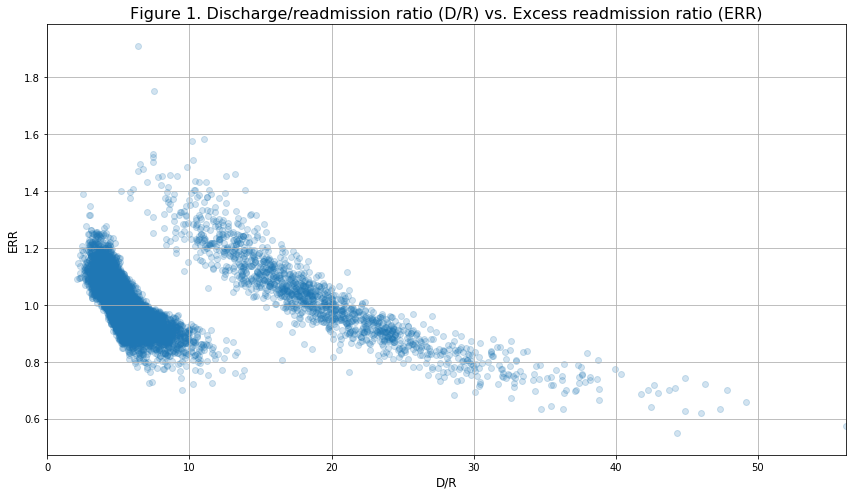

In [7]:
# Plot D/R vs. ERR
fig, ax = plt.subplots(figsize=(12,7))
ax.scatter(x,y,alpha=0.2)

ax.set_xlim([0, max(x)])
ax.set_xlabel('D/R', fontsize=12)
ax.set_ylabel('ERR', fontsize=12)

ax.set_title('Figure 1. Discharge/readmission ratio (D/R) vs. Excess readmission ratio (ERR)', fontsize=16)

ax.grid(True)
fig.tight_layout()

See below for cluster classification, further analysis to predict the clusters using features other than D/R and ERR, and finally correlation and t-test calculations on these clusters.

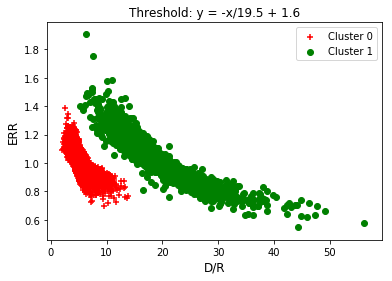

In [8]:
# Separate groups seen in Figure 1 using manually determined threshold line

for i in range(0, xy.shape[0]):
    if xy[i,1] <= -(1/19.5)*xy[i,0] + 1.6:
        c1 = plt.scatter(xy[i,0],xy[i,1],c='r',
                         marker='+')
    elif xy[i,1] > -(1/19.5)*xy[i,0] + 1.6:
        c2 = plt.scatter(xy[i,0],xy[i,1],c='g',
                         marker='o')
plt.legend([c1, 
            c2], 
           ['Cluster 0', 
            'Cluster 1'])
plt.xlabel('D/R', fontsize=12)
plt.ylabel('ERR', fontsize=12)
plt.title('Threshold: y = -x/19.5 + 1.6')
plt.show()

In [24]:
# The manual approach above works well, but a machine-
#  learning approach is desired.

# Separate groups seen in Figure 1 using DBSCAN

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import DBSCAN

ss = StandardScaler()
xy_t = ss.fit_transform(xy)
#xy_t_small = xy_t[::10]
                
db = DBSCAN(eps=0.5, min_samples=10, algorithm='kd_tree')
labels = db.fit_predict(xy_t)

In [25]:
# View the DBSCAN output labels (-1 is noise)
set(labels)

{-1, 0, 1}

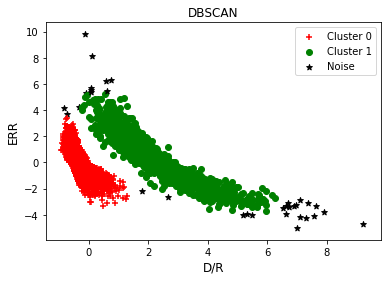

In [126]:
# Plot DBSCAN results
import matplotlib.pyplot as plt

for i in range(0, xy_t.shape[0]):
    if db.labels_[i] == 0:
        c1 = plt.scatter(xy_t[i,0],xy_t[i,1],c='r',
                         marker='+')
    elif db.labels_[i] == 1:
        c2 = plt.scatter(xy_t[i,0],xy_t[i,1],c='g',
                         marker='o')
    elif db.labels_[i] == -1:
        c4 = plt.scatter(xy_t[i,0],xy_t[i,1],c='k',
                         marker='*')
plt.legend([c1, 
            c2, 
            c4], 
           ['Cluster 0', 
            'Cluster 1', 
            'Noise'])
plt.xlabel('D/R', fontsize=12)
plt.ylabel('ERR', fontsize=12)
plt.title('DBSCAN')
plt.show()

In [26]:
# Run support vector machine (SVM) using 
#  non-noise labels output from DBSCAN above

# Create noise and non-noise datasets
xyl = np.column_stack((x,y,labels))
xyl_noise = xyl[np.where(xyl[:,2] == -1)]
xyl_nonoise = xyl[np.where(xyl[:,2] != -1)]

In [27]:
xyl_nonoise.shape

(11461, 3)

In [28]:
# Run support vector machine (SVM) using 
#  non-noise labels output from DBSCAN above

lin_clf = LinearSVC(random_state=42)
lin_clf.fit(xyl_nonoise[:,0:2], xyl_nonoise[:,2])

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=42, tol=0.0001,
     verbose=0)

In [29]:
# SVM: Predict on the non-noise set, measure accuracy,
#  and plot
labels_pred = lin_clf.predict(xyl_nonoise[:,0:2])
accuracy_score(xyl_nonoise[:,2], labels_pred)

1.0

In [30]:
labels_pred.shape

(11461,)

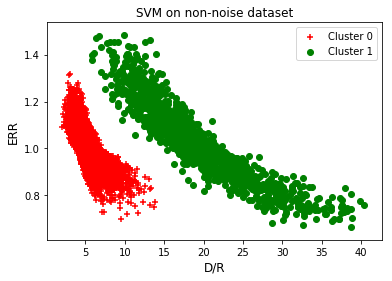

In [127]:
for i in range(0, xyl_nonoise.shape[0]):
    if labels_pred[i] == 0:
        c1 = plt.scatter(xyl_nonoise[i,0],xyl_nonoise[i,1],c='r',
                         marker='+')
    elif labels_pred[i] == 1:
        c2 = plt.scatter(xyl_nonoise[i,0],xyl_nonoise[i,1],c='g',
                         marker='o')
plt.legend([c1, 
            c2], 
           ['Cluster 0', 
            'Cluster 1'])
plt.xlabel('D/R', fontsize=12)
plt.ylabel('ERR', fontsize=12)
plt.title('SVM on non-noise dataset')
plt.show()

In [31]:
# SVM: predict on the full (noise & no-noise) set and plot 
full_labels_pred = lin_clf.predict(xyl[:,0:2])

In [32]:
set(full_labels_pred)

{0.0, 1.0}

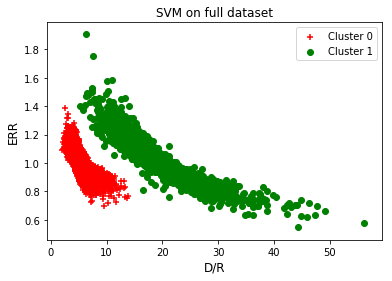

In [128]:
for i in range(0, xyl.shape[0]):
    if full_labels_pred[i] == 0:
        c1 = plt.scatter(xyl[i,0],xyl[i,1],c='r',
                         marker='+')
    elif full_labels_pred[i] == 1:
        c2 = plt.scatter(xyl[i,0],xyl[i,1],c='g',
                         marker='o')
plt.legend([c1, 
            c2], 
           ['Cluster 0', 
            'Cluster 1'])
plt.xlabel('D/R', fontsize=12)
plt.ylabel('ERR', fontsize=12)
plt.title('SVM on full dataset')
plt.show()

Using the above SVM model cluster labels, the below analysis uses decision tree to classify the clusters using other features, including substrings from the hospital name, and US state-level information (area, population, latitude, longitude) for the hospital's state.

In [33]:
# Add full labels from SVM to dataset
xylf = np.column_stack((xyl, full_labels_pred))

In [41]:
# Decision tree
tree_clf = DecisionTreeClassifier(max_depth=2)
tree_clf.fit(xylf[:,0:2], xylf[:,3])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [42]:
# Tree: predict on the full set, measure accuracy, and plot
tree_labels_pred = tree_clf.predict(xylf[:,0:2])
accuracy_score(xylf[:,3], tree_labels_pred)

0.9939098660170523

In [44]:
set(tree_labels_pred)

{0.0, 1.0}

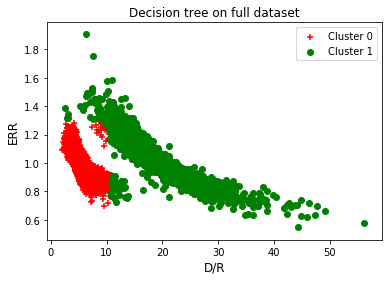

In [129]:
for i in range(0, xylf.shape[0]):
    if tree_labels_pred[i] == 0:
        c1 = plt.scatter(xylf[i,0],xylf[i,1],c='r',
                         marker='+')
    elif tree_labels_pred[i] == 1:
        c2 = plt.scatter(xylf[i,0],xylf[i,1],c='g',
                         marker='o')
plt.legend([c1, 
            c2], 
           ['Cluster 0', 
            'Cluster 1'])
plt.xlabel('D/R', fontsize=12)
plt.ylabel('ERR', fontsize=12)
plt.title('Decision tree on full dataset')
plt.show()

In [134]:
# This outputs .dot file which can be plotted on www.webgraphiz.com
export_graphviz(tree_clf, out_file="tree1.dot", class_names=["Cluster 0", "Cluster 1"])

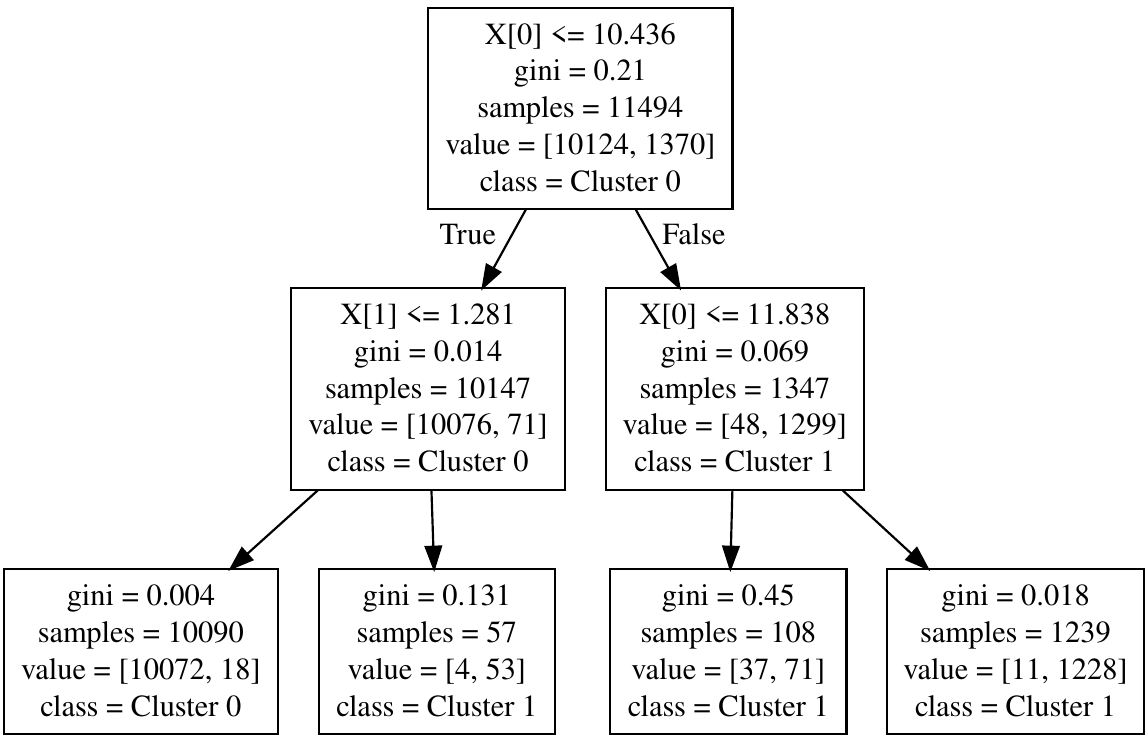

In [45]:
# Set up dummy variables for select Hospital Name words
#
# Bring lowercase Hospital Name string into new variable and then clean it

clean_82["hospital name"] = [x.replace('-',' ') for x in clean_82["Hospital Name"].str.lower()]

clean_82["hospital name"] = [x.replace(' & ',' ') for x in clean_82["hospital name"]]
clean_82["hospital name"] = [x.replace(' and ',' ') for x in clean_82["hospital name"]]
clean_82["hospital name"] = [x.replace('the ',' ') for x in clean_82["hospital name"]]
clean_82["hospital name"] = [x.replace(' at ',' ') for x in clean_82["hospital name"]]
clean_82["hospital name"] = [x.replace(' of ',' ') for x in clean_82["hospital name"]]
clean_82["hospital name"] = [x.replace(',',' ') for x in clean_82["hospital name"]]
clean_82["hospital name"] = [x.replace('saint','st') for x in clean_82["hospital name"]]
clean_82["hospital name"] = [x.replace('ctr','center') for x in clean_82["hospital name"]]
clean_82["hospital name"] = [x.replace("'",'') for x in clean_82["hospital name"]]
clean_82["hospital name"] = [x.replace('marys','mary') for x in clean_82["hospital name"]]
clean_82["hospital name"] = [x.replace('lukes','luke') for x in clean_82["hospital name"]]
clean_82["hospital name"] = [x.replace('josephs','joseph') for x in clean_82["hospital name"]]
clean_82["hospital name"] = [x.replace('johns','john') for x in clean_82["hospital name"]]
clean_82["hospital name"] = [x.replace('vincents','vincent') for x in clean_82["hospital name"]]

In [46]:
# Count each word and obtain dummy variable (one-hot encoding)
#  for the 50 most frequent words, and view them
h_str_50 = pd.Series(' '.join(clean_82["hospital name"]).lower().split()).value_counts()[:50].index.values
h_str_50

array(['hospital', 'center', 'medical', 'regional', 'st', 'memorial',
       'health', 'community', 'university', 'inc', 'general', 'mercy',
       'valley', 'county', 'mary', 'joseph', 'system', 'baptist', 'north',
       'west', 'methodist', 'healthcare', 'south', 'luke', 'texas',
       'john', 'east', 'francis', 'providence', 'hospitals', 'campus',
       'samaritan', 'good', 'heart', 'city', 'vincent', 'presbyterian',
       'clinic', 'san', 'florida', 'lake', 'central', 'park', 'med',
       'river', 'doctors', 'franciscan', 'southern', 'elizabeth',
       'northwest'], dtype=object)

In [47]:
clean_82.to_csv('data/clean_82.csv')

In [ ]:
# Break here if needed

In [48]:
clean_82=pd.read_csv('data/clean_82.csv')
clean_82.shape

(11494, 14)

In [49]:
# Create new variables for each of the top 50 words
for k in range(h_str_50.shape[0]):
    clean_82[h_str_50[k]] = clean_82.apply(lambda _: 0, axis=1)

In [50]:
clean_82.shape

(11494, 64)

In [51]:
# Specify new variables as dummy variables for presence
#  of its given word 
#  (printout shows progress by line)

line=0
for i in range(clean_82.shape[0]):
    line+=1
    col=13
    for j in range(h_str_50.shape[0]):
        col+=1
        if h_str_50[j] in clean_82.iloc[i,13]:
            clean_82.iloc[i,col] = 1
        print(line, end='\r')

In [ ]:
# Check dummies created appropriately
pd.options.display.max_columns = 100
clean_82.head(50)

In [53]:
clean_82.to_csv('data/clean_82dummy.csv')

In [54]:
# Break here if needed

In [55]:
clean_82dummy=pd.read_csv('data/clean_82dummy.csv')
clean_82dummy.shape

(11494, 65)

In [56]:
# Load in states data
#  (source: https://inkplant.com/code/us-state-mysql-table)

states_df = pd.read_csv('data/states_data.csv')

In [57]:
states_df.head()

,name,abv,country,is_state,is_lower48,slug,latitude,longitude,population,area
0,Alabama,AL,US,y,y,alabama,32.806671,-86.791130,4779736,50744.00
1,Alaska,AK,US,y,n,alaska,61.370716,-152.404419,710231,571951.25
2,Arizona,AZ,US,y,y,arizona,33.729759,-111.431221,6392017,113634.57
3,Arkansas,AR,US,y,y,arkansas,34.969704,-92.373123,2915918,52068.17
4,California,CA,US,y,y,california,36.116203,-119.681564,37253956,155939.52


In [58]:
# Convert xylf array to dataframe, naming variables,
#  then concatenate to clean_82 state and dummy columns,
#  then left merge to states_df along State/Abv value 

xyf_df = pd.DataFrame({'D/R':xylf[:,0],'ERR':xylf[:,1],'SVM_label':xylf[:,3]})

dum_xyf = pd.concat([clean_82dummy, xyf_df], axis=1)

dum_xyf_st = pd.merge(dum_xyf, states_df[['name','abv','latitude','longitude','population','area']], 
                      how='left', left_on='State', right_on='abv')
dum_xyf_st.head()

,Unnamed: 0,Unnamed: 0.1,Hospital Name,Provider Number,State,Measure Name,Number of Discharges,Footnote,Excess Readmission Ratio,Predicted Readmission Rate,Expected Readmission Rate,Number of Readmissions,Start Date,End Date,hospital name,hospital,center,medical,regional,st,memorial,health,community,university,inc,general,mercy,valley,county,mary,joseph,system,baptist,north,west,methodist,healthcare,south,luke,texas,john,east,francis,providence,hospitals,campus,samaritan,good,heart,city,vincent,presbyterian,clinic,san,florida,lake,central,park,med,river,doctors,franciscan,southern,elizabeth,northwest,D/R,ERR,SVM_label,name,abv,latitude,longitude,population,area
0,0,1832,UNIVERSITY OF MD CHARLES REGIONAL MEDICAL CENTER,210035,MD,READM-30-AMI-HRRP,25,NaN,1.0914,26.8,24.6,12.0,07/01/2010,06/30/2013,university md charles regional medical center,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2.083333,1.0914,0.0,Maryland,MD,39.063946,-76.802101,5773552,9773.82
1,1,1699,ATLANTIC GENERAL HOSPITAL,210061,MD,READM-30-AMI-HRRP,27,NaN,1.0961,24.8,22.6,12.0,07/01/2010,06/30/2013,atlantic general hospital,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.250000,1.0961,0.0,Maryland,MD,39.063946,-76.802101,5773552,9773.82
2,2,1774,MERCY MEDICAL CENTER INC,210008,MD,READM-30-AMI-HRRP,28,NaN,1.0934,24.4,22.3,12.0,07/01/2010,06/30/2013,mercy medical center inc,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,2.333333,1.0934,0.0,Maryland,MD,39.063946,-76.802101,5773552,9773.82
3,3,1853,KAISER FOUNDATION HOSPITAL-SANTA CLARA,50071,CA,READM-30-HF-HRRP,29,NaN,1.0908,21.0,19.3,11.0,07/01/2010,06/30/2013,kaiser foundation hospital santa clara,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,2.636364,1.0908,0.0,California,CA,36.116203,-119.681564,37253956,155939.52
4,4,1290,PALMERTON HOSPITAL,390019,PA,READM-30-AMI-HRRP,30,NaN,1.1123,23.2,20.9,13.0,07/01/2010,06/30/2013,palmerton hospital,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2.307692,1.1123,0.0,Pennsylvania,PA,40.590752,-77.209755,12702379,44816.61


In [59]:
dum_xyf_st.to_csv('data/dum_xyf_st.csv')

In [60]:
del xyf_df
del dum_xyf

In [61]:
# Break here if needed

In [62]:
dum_xyf_st=pd.read_csv('data/dum_xyf_st.csv')
dum_xyf_st.shape

(11494, 75)

In [63]:
dum_xyf_st.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11494 entries, 0 to 11493
Data columns (total 75 columns):
Unnamed: 0                    11494 non-null int64
Unnamed: 0.1                  11494 non-null int64
Unnamed: 0.1.1                11494 non-null int64
Hospital Name                 11494 non-null object
Provider Number               11494 non-null int64
State                         11494 non-null object
Measure Name                  11494 non-null object
Number of Discharges          11494 non-null int64
Footnote                      0 non-null float64
Excess Readmission Ratio      11494 non-null float64
Predicted Readmission Rate    11494 non-null float64
Expected Readmission Rate     11494 non-null float64
Number of Readmissions        11494 non-null float64
Start Date                    11494 non-null object
End Date                      11494 non-null object
hospital name                 11494 non-null object
hospital                      11494 non-null int64
center      

In [64]:
new_tree_df = dum_xyf_st[['Provider Number',
                           'State',
                           'name',                  
                           'D/R',         
                           'ERR',
                           'latitude',    
                           'longitude',   
                           'population',  
                           'area',
                           'hospital',
                           'center',  
                           'medical', 
                           'regional',
                           'st',      
                           'memorial',
                           'health',  
                           'community',
                           'university', 
                           'inc',        
                           'general',    
                           'mercy',      
                           'valley',     
                           'county',     
                           'mary',       
                           'joseph',     
                           'system',     
                           'baptist',    
                           'north',      
                           'west',       
                           'methodist',  
                           'healthcare', 
                           'south',      
                           'luke',       
                           'john',       
                           'texas',      
                           'east',       
                           'francis',    
                           'providence', 
                           'hospitals',  
                           'campus',     
                           'samaritan',  
                           'good',       
                           'heart',      
                           'city',        
                           'vincent',     
                           'presbyterian',
                           'clinic',      
                           'san',         
                           'florida',     
                           'lake',        
                           'central',     
                           'park',        
                           'med',         
                           'river',       
                           'doctors',     
                           'southern',    
                           'franciscan',  
                           'elizabeth',
                           'northwest']]
new_tree_df["target"]=dum_xyf_st[['SVM_label']]

In [65]:
new_tree_df.head()

,Provider Number,State,name,D/R,ERR,latitude,longitude,population,area,hospital,center,medical,regional,st,memorial,health,community,university,inc,general,mercy,valley,county,mary,joseph,system,baptist,north,west,methodist,healthcare,south,luke,john,texas,east,francis,providence,hospitals,campus,samaritan,good,heart,city,vincent,presbyterian,clinic,san,florida,lake,central,park,med,river,doctors,southern,franciscan,elizabeth,northwest,target
0,210035,MD,Maryland,2.083333,1.0914,39.063946,-76.802101,5773552,9773.82,0,1,1,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0
1,210061,MD,Maryland,2.250000,1.0961,39.063946,-76.802101,5773552,9773.82,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0
2,210008,MD,Maryland,2.333333,1.0934,39.063946,-76.802101,5773552,9773.82,0,1,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0.0
3,50071,CA,California,2.636364,1.0908,36.116203,-119.681564,37253956,155939.52,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0.0
4,390019,PA,Pennsylvania,2.307692,1.1123,40.590752,-77.209755,12702379,44816.61,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0


In [84]:
# Count hospitals in cluster 0 and cluster 1
unique, counts = np.unique(new_tree_df.target.values, return_counts=True)
dict(zip(unique, counts))

{0.0: 10124, 1.0: 1370}

In [86]:
# To balance the dataset, we will up-sample the cluster 1
#  hospitals to bring the Cluster 1 count up to the
#  Cluster 0 count.
#  (adapted from: https://elitedatascience.com/imbalanced-classes)

# Create majority and minority dataframes
df_majority = new_tree_df[new_tree_df.target==0]
df_minority = new_tree_df[new_tree_df.target==1]
 
# Upsample minority dataframe
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # with replacement
                                 n_samples=10124,    # match majority count
                                 random_state=123) # reproducible
 
# Combine majority with upsampled minority dataframes
new_tree_dfup = pd.concat([df_majority, df_minority_upsampled])

# Clean up
del df_majority
del df_minority
del df_minority_upsampled

# Check
unique, counts = np.unique(new_tree_dfup.target.values, return_counts=True)
dict(zip(unique, counts))

{0.0: 10124, 1.0: 10124}

In [87]:
new_tree_arr = new_tree_dfup.iloc[:,3:].values

In [88]:
new_tree_arr.shape

(20248, 57)

In [99]:
# New Tree: Perform decision tree again, now on expanded set of features
new_tree_clf = DecisionTreeClassifier(max_depth=50)
new_tree_clf.fit(new_tree_arr[:,2:56], new_tree_arr[:,56])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [100]:
# New Tree: Predict, measure accuracy, and plot
new_tree_labels_pred = new_tree_clf.predict(new_tree_arr[:,2:56])
accuracy_score(new_tree_arr[:,56], new_tree_labels_pred)

0.6716712761754248

In [101]:
unique, counts = np.unique(new_tree_labels_pred, return_counts=True)
dict(zip(unique, counts))

{0.0: 7760, 1.0: 12488}

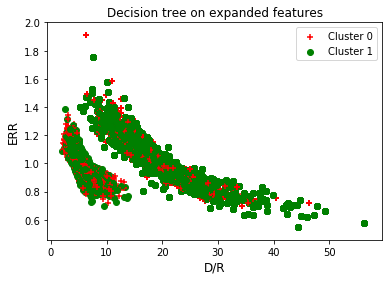

In [102]:
for i in range(0, new_tree_arr.shape[0]):
    if new_tree_labels_pred[i] == 0:
        c1 = plt.scatter(new_tree_arr[i,0],new_tree_arr[i,1],c='r',
                         marker='+')
    elif new_tree_labels_pred[i] == 1:
        c2 = plt.scatter(new_tree_arr[i,0],new_tree_arr[i,1],c='g',
                         marker='o')
plt.legend([c1, 
            c2], 
           ['Cluster 0', 
            'Cluster 1'])
plt.xlabel('D/R', fontsize=12)
plt.ylabel('ERR', fontsize=12)
plt.title('Decision tree on expanded features')
plt.show()

In [103]:
# Output .dot file which can be plotted on www.webgraphiz.com
export_graphviz(new_tree_clf, out_file="tree2.dot", 
                feature_names=['latitude',    
                               'longitude',   
                               'population',  
                               'area',
                               'hospital',
                               'center',  
                               'medical', 
                               'regional',
                               'st',      
                               'memorial',
                               'health',  
                               'community',
                               'university', 
                               'inc',        
                               'general',    
                               'mercy',      
                               'valley',     
                               'county',     
                               'mary',       
                               'joseph',     
                               'system',     
                               'baptist',    
                               'north',      
                               'west',       
                               'methodist',  
                               'healthcare', 
                               'south',      
                               'luke',       
                               'john',       
                               'texas',      
                               'east',       
                               'francis',    
                               'providence', 
                               'hospitals',  
                               'campus',     
                               'samaritan',  
                               'good',       
                               'heart',      
                               'city',        
                               'vincent',     
                               'presbyterian',
                               'clinic',      
                               'san',         
                               'florida',     
                               'lake',        
                               'central',     
                               'park',        
                               'med',         
                               'river',       
                               'doctors',     
                               'southern',    
                               'franciscan',  
                               'elizabeth',
                               'northwest'],
                class_names=["Cluster 0", "Cluster 1"])

In [104]:
# This tree is too complex to plot, so we'll go straight to 
#  viewing feature importance
features =                    ['latitude',    
                               'longitude',   
                               'population',  
                               'area',
                               'hospital',
                               'center',  
                               'medical', 
                               'regional',
                               'st',      
                               'memorial',
                               'health',  
                               'community',
                               'university', 
                               'inc',        
                               'general',    
                               'mercy',      
                               'valley',     
                               'county',     
                               'mary',       
                               'joseph',     
                               'system',     
                               'baptist',    
                               'north',      
                               'west',       
                               'methodist',  
                               'healthcare', 
                               'south',      
                               'luke',       
                               'john',       
                               'texas',      
                               'east',       
                               'francis',    
                               'providence', 
                               'hospitals',  
                               'campus',     
                               'samaritan',  
                               'good',       
                               'heart',      
                               'city',        
                               'vincent',     
                               'presbyterian',
                               'clinic',      
                               'san',         
                               'florida',     
                               'lake',        
                               'central',     
                               'park',        
                               'med',         
                               'river',       
                               'doctors',     
                               'southern',    
                               'franciscan',  
                               'elizabeth',
                               'northwest']
for feature, score in sorted(zip(features, new_tree_clf.feature_importances_), key = lambda x:x[1], reverse=True):
    print('{:12}'.format(feature), round(score, 4))

population   0.0877
latitude     0.0803
longitude    0.0584
area         0.0572
hospital     0.0437
st           0.037
regional     0.0345
health       0.0292
center       0.0284
university   0.0256
inc          0.0236
north        0.0233
san          0.0231
community    0.0229
med          0.0227
memorial     0.0221
south        0.0218
mary         0.021
lake         0.0202
county       0.0176
john         0.0161
general      0.016
mercy        0.0157
park         0.0152
east         0.0151
valley       0.0141
medical      0.0134
system       0.0134
west         0.0123
heart        0.0114
texas        0.0113
central      0.0106
river        0.0103
city         0.0102
joseph       0.0102
clinic       0.009
doctors      0.0081
providence   0.008
presbyterian 0.0078
northwest    0.0076
samaritan    0.0073
methodist    0.007
hospitals    0.0068
baptist      0.0068
campus       0.0059
healthcare   0.0049
southern     0.0046
good         0.0043
luke         0.0038
florida      0.0036
franci

In [ ]:
# Interestingly, state-level features (area, latitude, longitude, 
#  population) are most predictive of clusters

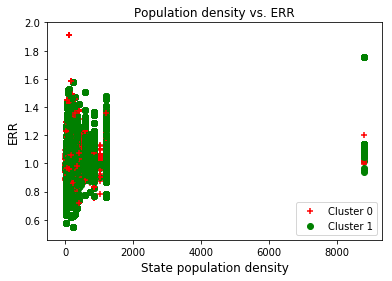

In [105]:
# We take a look at population density (population/area)
#  plotted against ERR, color coded for clusters
#  (note the outlier for DC)

for i in range(0, new_tree_arr.shape[0]):
    if new_tree_labels_pred[i] == 0:
        c1 = plt.scatter(new_tree_arr[i,4]/new_tree_arr[i,5],new_tree_arr[i,1],c='r',
                         marker='+')
    elif new_tree_labels_pred[i] == 1:
        c2 = plt.scatter(new_tree_arr[i,4]/new_tree_arr[i,5],new_tree_arr[i,1],c='g',
                         marker='o')
plt.legend([c1, 
            c2], 
           ['Cluster 0', 
            'Cluster 1'])
plt.xlabel('State population density', fontsize=12)
plt.ylabel('ERR', fontsize=12)
plt.title('Population density vs. ERR')
plt.show()

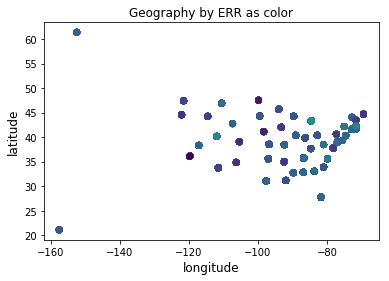

In [106]:
# Plot longitude by latitude, coloring by ERR
plt.scatter(new_tree_df['longitude'].values,new_tree_df['latitude'].values,c=new_tree_df['ERR'].values)
plt.xlabel('longitude', fontsize=12)
plt.ylabel('latitude', fontsize=12)
plt.title('Geography by ERR as color')
plt.show()

The plots do not clearly show population density or geography to be correlated with ERR. We hypothesize that it is the state identity itself that is predictive of ERR. 

Below, dummy variables are created for each state, and then used for a new decision tree.

In [112]:
state_dum = pd.get_dummies(new_tree_dfup['State'], prefix='sdum_')

In [113]:
state_dum.head()

,sdum__AK,sdum__AL,sdum__AR,sdum__AZ,sdum__CA,sdum__CO,sdum__CT,sdum__DC,sdum__DE,sdum__FL,sdum__GA,sdum__HI,sdum__IA,sdum__ID,sdum__IL,sdum__IN,sdum__KS,sdum__KY,sdum__LA,sdum__MA,sdum__MD,sdum__ME,sdum__MI,sdum__MN,sdum__MO,sdum__MS,sdum__MT,sdum__NC,sdum__ND,sdum__NE,sdum__NH,sdum__NJ,sdum__NM,sdum__NV,sdum__NY,sdum__OH,sdum__OK,sdum__OR,sdum__PA,sdum__RI,sdum__SC,sdum__SD,sdum__TN,sdum__TX,sdum__UT,sdum__VA,sdum__VT,sdum__WA,sdum__WI,sdum__WV,sdum__WY
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0


In [124]:
state_dum_arr = state_dum.values

In [125]:
#state_dum_arr = np.column_stack((state_dum_arr,new_tree_arr[:,2]))

In [126]:
state_dum_arr.shape

(20248, 51)

In [127]:
state_tree_clf = DecisionTreeClassifier(max_depth=50)
state_tree_clf.fit(state_dum_arr[:,:], new_tree_arr[:,56])

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=50,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [128]:
state_tree_labels_pred = state_tree_clf.predict(state_dum_arr[:,:])
accuracy_score(new_tree_arr[:,56], state_tree_labels_pred)

0.5529928881864875

In [129]:
unique, counts = np.unique(state_tree_labels_pred, return_counts=True)
dict(zip(unique, counts))

{0.0: 8291, 1.0: 11957}

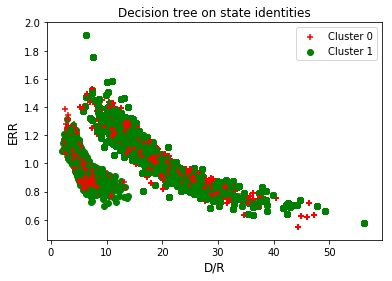

In [130]:
for i in range(0, new_tree_arr.shape[0]):
    if state_tree_labels_pred[i] == 0:
        c1 = plt.scatter(new_tree_arr[i,0],new_tree_arr[i,1],c='r',
                         marker='+')
    elif state_tree_labels_pred[i] == 1:
        c2 = plt.scatter(new_tree_arr[i,0],new_tree_arr[i,1],c='g',
                         marker='o')
plt.legend([c1, 
            c2], 
           ['Cluster 0', 
            'Cluster 1'])
plt.xlabel('D/R', fontsize=12)
plt.ylabel('ERR', fontsize=12)
plt.title('Decision tree on state identities')
plt.show()

The features examined so far do not do a good job classifying the two clusters.  

## Calculations for statistics mentioned in anwers:

In [74]:
pcc0, p20 = pearsonr(new_tree_arr[:,0][np.where(new_tree_arr[:,56] == 0)], new_tree_arr[:,1][np.where(new_tree_arr[:,56] == 0)])
print('For Cluster 0:\n', 
      'The Pearson correlation coefficient for D/R on ERR is:', round(pcc0, 5), 
      '\n The two-tailed p-value for this coefficient is:', p20)

For Cluster 0:
 The Pearson correlation coefficient for D/R on ERR is: -0.74472 
 The two-tailed p-value for this coefficient is: 0.0


In [75]:
pcc1, p21 = pearsonr(new_tree_arr[:,0][np.where(new_tree_arr[:,56] == 1)], new_tree_arr[:,1][np.where(new_tree_arr[:,56] == 1)])
print('For Cluster 1:\n', 
      'The Pearson correlation coefficient for D/R on ERR is:', round(pcc1, 5), 
      '\n The two-tailed p-value for this coefficient is:', p21)

For Cluster 1:
 The Pearson correlation coefficient for D/R on ERR is: -0.89797 
 The two-tailed p-value for this coefficient is: 0.0


In [76]:
print('For Cluster 0, the ERR mean is:', 
      round(np.mean(new_tree_arr[:,1][np.where(new_tree_arr[:,56] == 0)]), 5))

For Cluster 0, the ERR mean is: 1.00477


In [77]:
print('For Cluster 1, the ERR mean is:', 
      round(np.mean(new_tree_arr[:,1][np.where(new_tree_arr[:,56] == 1)]), 5))

For Cluster 1, the ERR mean is: 1.028


In [78]:
statistic, pmeans = scipy.stats.ttest_ind(new_tree_arr[:,1][np.where(new_tree_arr[:,56] == 0)], 
                      new_tree_arr[:,1][np.where(new_tree_arr[:,56] == 1)])
print('Using the t-test, the p-value for difference between\n',
      ' the Cluster 0 and Cluster 1 ERR means is:', pmeans) 

Using the t-test, the p-value for difference between
  the Cluster 0 and Cluster 1 ERR means is: 1.4622092535107237e-18
